In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import datetime
import pprint
import scipy.optimize as sco
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
'''
基本数据导入 - 绝对路径，需要修改
'''

In [355]:
## 四板块
Class = ['券商','银行','房地产','保险']

In [356]:
## 周期数据
## 日度
MacroDataDaily = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/宏观经济指标.xlsx').dropna()
MacroDataDaily['M'] = MacroDataDaily['中债国债到期收益率:1年']
MacroDataDaily['C'] = MacroDataDaily['中债企业债到期收益率(AA):3年'] - MacroDataDaily['中债企业债到期收益率(AAA):3年']
## 日期调整 - 月末数据取股票交易日月末
stocktest = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/券商.xlsx')['date'].tolist()
MacroDataDaily = MacroDataDaily[MacroDataDaily['date'].isin(stocktest)]
## 月度 - 每月最后一天
MacroDataMonthly = MacroDataDaily.copy()
MacroDataMonthly['trade_date'] = MacroDataDaily['date']
MacroDataMonthly = MacroDataMonthly.set_index('date').apply(lambda x: x.resample('M').last()).reset_index()

In [357]:
## 全数据 - 面板数据堆叠形式
qs = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/券商.xlsx')
yh = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/银行.xlsx')
fdc = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/房地产.xlsx')
bx = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/保险.xlsx')

qs['return'] = qs['close']/qs['close'].shift(1)-1
yh['return'] = yh['close']/yh['close'].shift(1)-1
fdc['return'] = fdc['close']/fdc['close'].shift(1)-1
bx['return'] = bx['close']/bx['close'].shift(1)-1

qs['class'] = '券商'
yh['class'] = '银行'
fdc['class'] = '房地产'
bx['class'] = '保险'

FinDataDf = pd.concat([qs,yh,fdc,bx],axis=0,sort=False)

In [358]:
## 债券数据
Bond = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/上证国债.xlsx')

In [359]:
## 起止时间设定
DataStart = '2009-08-31'
StrategyStart = '2014-01-30'
End = '2019-06-30'

MacroDataMonthlySub = MacroDataMonthly[(MacroDataMonthly['trade_date']>=DataStart) & (MacroDataMonthly['trade_date']<=End)].copy()
FinDataDfSub = FinDataDf[(FinDataDf['date']<=End) & (FinDataDf['date']>=DataStart)].copy()
FinDataDfSubReturn = FinDataDfSub.pivot(index='date',columns='class',values='return').reset_index()

In [360]:
## 实行策略时点 - 交易日历的月末
MacroDataMonthlySubForStrategy = MacroDataMonthlySub[MacroDataMonthlySub['trade_date']>=StrategyStart]
StrategyDateDf = MacroDataMonthlySubForStrategy[['trade_date']].rename(columns={'trade_date':'StrategyDate'})
StrategyDateList = StrategyDateDf['StrategyDate'].tolist()

In [361]:
## 基准数据导入
BenchmarkIndex = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/中证金融地产.xlsx')
BenchmarkFund = pd.read_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/华商基金数据/工银瑞信金融地产.xlsx')

BenchmarkIndex['return'] = BenchmarkIndex['close']/BenchmarkIndex['close'].shift(1)-1
BenchmarkFund['return'] = BenchmarkFund['close']/BenchmarkFund['close'].shift(1)-1

BenchmarkIndexSub = BenchmarkIndex[(BenchmarkIndex['date']>=StrategyStart) & (BenchmarkIndex['date']<=End)]
BenchmarkFundSub = BenchmarkFund[(BenchmarkFund['date']>=StrategyStart) & (BenchmarkFund['date']<=End)]

In [ ]:
'''
策略所需数据/指标/信号计算
'''

In [ ]:
'''
1货币信用周期指标计算
'''

In [362]:
## 货币信用周期指标1 - T~T-3正负占比
def MoneyCredit1(series):
    MList = series.tolist()
    MResultTmp = []
    for i in range(len(MList)-1):
        if MList[-1]-MList[i]>=0:
            MResultTmp.append(1)
        else:
            MResultTmp.append(-1)
    MResult = np.sum(MResultTmp)
    return MResult
def MoneyCredit2(series):
    MList = series.tolist()
    MResultTmp = []
    MResult = MList[-1] - MList[-2]
    return MResult
def MoneyCredit3(series):
    MList = series.tolist()
    MResultTmp = []
    MResult = (MList[-1] + MList[-2]) - (MList[-3] + MList[-4])
    return MResult
MacroDataMonthlySub['DeltaC'] = MacroDataMonthlySub['C'].rolling(4).apply(MoneyCredit1,raw=True)
MacroDataMonthlySub['DeltaM'] = MacroDataMonthlySub['M'].rolling(4).apply(MoneyCredit1,raw=True)
def MCcycle(df):
    if df['DeltaC']>0:
        C='R'
    else:
        C='E'
    if df['DeltaM']>0:
        M='R'
    else:
        M='E'
    return 'M'+M+' C'+C
MacroDataMonthlySub['MCcycle'] = MacroDataMonthlySub.apply(lambda x: MCcycle(x),axis=1)
MCcycleDf = MacroDataMonthlySub[['trade_date','MCcycle']]

In [363]:
'''
2周期表示
'''
CycleList = ['ME CE','ME CR','MR CR','MR CE']

In [ ]:
'''
3各周期与对应月的收益数据合并
'''

In [364]:
## 月收益率
FinDataDfSubClose = FinDataDfSub.pivot(index='date',columns='class',values='close')
FinDataDfSubClose['trade_date'] = FinDataDfSubClose.index
FinDataDfSubReturnM = FinDataDfSubClose.apply(lambda x: x.resample('M').last()).set_index('trade_date').pct_change().reset_index().dropna()

## 收益率与周期合并
CycleAndReturn = FinDataDfSubReturnM.merge(MCcycleDf,on=['trade_date'],how='left')

In [ ]:
'''
4各板块历史排名滚动平均值计算
'''

In [365]:
RollingMonth = 48

# 计算排名序号，按收益率从大到小排序
def RankCompute(df):
    df = df.copy()
    trade_date = df['trade_date'].tolist()[0]
    dfSub = df[Class]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,5)
    tmpDf1 = tmpDf0.T[Class]
    tmpDf1.index = [trade_date]
    return tmpDf1

# 并行计算函数
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,sort=False)

# 全周期下历史平均排名
RollingRankAllDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankAllDf = pd.concat([RollingRankAllDf,RollingRank],axis=0)
RollingRankAllDf.columns = [i+'RankAll' for i in RollingRankAllDf.columns]

# 当前周期的历史同周期平均排名
RollingRankCycleDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    CycleNow = CycleAndReturnSub['MCcycle'].tolist()[-1]
    CycleAndReturnSub = CycleAndReturnSub[CycleAndReturnSub['MCcycle']==CycleNow]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankCycleDf = pd.concat([RollingRankCycleDf,RollingRank],axis=0)
RollingRankCycleDf.columns = [i+'RankCycle' for i in RollingRankCycleDf.columns]

In [ ]:
'''
5排名+周期+月度+收益率拼接 - 底稿
'''

In [366]:
AllDataForBackTest = CycleAndReturn.merge(RollingRankCycleDf.merge(RollingRankAllDf,left_index=True,right_index=True),left_on='trade_date',right_index=True,how='left')

In [ ]:
'''
注：4/5 and 6 只跑其中一组
6测试阶段-未来周期预测-日度数据扩充样本，预测未来21日
'''

In [367]:
# 周度数据
MacroDataDailyForPredict = MacroDataDaily.copy()
# MacroDataDailyForPredict['trade_date'] = MacroDataDailyForPredict['date']
# MacroDataWeeklyForPredict = MacroDataDailyForPredict.set_index('date').apply(lambda x: x.resample("W").last()).dropna()

# 变量构造
# 历史四月涨跌
def ComputeChange1M(series):
    return series[-1] - series[-22]
def ComputeChange2M(series):
    return series[-1] - series[-43]
def ComputeChange3M(series):
    return series[-1] - series[-64]
def ComputeChange4M(series):
    return series[-1] - series[-85]

for Mchange in range(1,5):
    exec('''MacroDataDailyForPredict['Change%sM'] = MacroDataDailyForPredict['M'].rolling(85).apply(ComputeChange%sM,raw=True)''' %(Mchange,Mchange))
for Mchange in range(1,5):
    exec('''MacroDataDailyForPredict['Change%sC'] = MacroDataDailyForPredict['C'].rolling(85).apply(ComputeChange%sM,raw=True)''' %(Mchange,Mchange))

# 周期判断
def MoneyCreditR64(series):
    MList = series.tolist()
    MResultTmp = []
    for i in range(3):
        j = (i+1)*21 + 1
        if MList[-1]-MList[-(j)]>=0:
            MResultTmp.append(1)
        else:
            MResultTmp.append(-1)
    MResult = np.sum(MResultTmp)
    return MResult
def MCcycle(df):
    if df['DeltaC']>0:
        C='R'
    else:
        C='E'
    if df['DeltaM']>0:
        M='R'
    else:
        M='E'
    return 'M'+M+' C'+C
MacroDataDailyForPredict['DeltaM'] = MacroDataDailyForPredict['M'].rolling(64).apply(MoneyCreditR64,raw=True)
MacroDataDailyForPredict['DeltaC'] = MacroDataDailyForPredict['C'].rolling(64).apply(MoneyCreditR64,raw=True)
MacroDataDailyForPredict['MCcycle'] = MacroDataDailyForPredict.apply(lambda x: MCcycle(x),axis=1)
MacroDataDailyForPredict['Mcycle'] = MacroDataDailyForPredict['DeltaM'].apply(lambda x: 'R' if x>0 else 'E')
MacroDataDailyForPredict['Ccycle'] = MacroDataDailyForPredict['DeltaC'].apply(lambda x: 'R' if x>0 else 'E')
# MCcycleDf = MacroDataDailyForPredict[['trade_date','MCcycle']]

In [ ]:
'''
6.1测试阶段-滚动预测效果评价（不用一直跑，仅测试时跑）
'''

In [433]:
ScoreSaveList = []
y_test_all = []
y_predict_all = []
for MonthEndDate in CycleAndReturn['trade_date'].tolist():
    end_date = MonthEndDate
    MacroDataDailyForPredictSub = MacroDataDailyForPredict[MacroDataDailyForPredict['date']<=end_date].copy()
    MacroDataDailyForPredictSub['Mcycle_21'] = MacroDataDailyForPredictSub['Mcycle'].shift(-21)
    MacroDataDailyForPredictSubTrain = MacroDataDailyForPredictSub.dropna()
    flag = 42
    X = MacroDataDailyForPredictSubTrain[['M', 'Change1M', 'Change2M', 'Change3M','Change4M',  'DeltaM']].iloc[:-flag,:]
    X_test = MacroDataDailyForPredictSubTrain[['M', 'Change1M', 'Change2M', 'Change3M','Change4M',  'DeltaM']].iloc[-flag:,:]
    y = MacroDataDailyForPredictSubTrain[['Mcycle_21']].iloc[:-flag,:]
    y_test = MacroDataDailyForPredictSubTrain[['Mcycle_21']].iloc[-flag:,:]
    # 训练决策树
#     cycleEvaluation = tree.DecisionTreeClassifier(class_weight = "balanced")
    # 训练支持向量机
#     cycleEvaluation = svm.SVC(C=0.1, kernel='linear', gamma='auto' ,decision_function_shape='ovr',class_weight = "balanced")
    # 训练朴素贝叶斯
#     cycleEvaluation = GaussianNB()
#     cycleEvaluation = MultinomialNB()
    cycleEvaluation = BernoulliNB()
    
    cycleEvaluation = cycleEvaluation.fit(X, np.array(y).ravel())
    y_train_predict = cycleEvaluation.predict(X)
    y_test_predict = cycleEvaluation.predict(X_test)
    y_predict_all += list(y_test_predict)
    y_test_all += y_test[y_test.columns[0]].tolist()
    
    # 评估
#     print('trainAccracy:',cycleEvaluation.score(X, y))
#     print(classification_report(y,y_train_predict))
#     print('testAccracy:',cycleEvaluation.score(X_test,y_test))
#     print(classification_report(y_test,y_test_predict))
    score = cycleEvaluation.score(X_test,np.array(y_test).ravel())
    ScoreSaveList.append(score)

In [ ]:
'''
6.2测试阶段-新真实周期判断方法-每日判断取众数
'''

In [434]:
# 计算每月周期-取日度结果众数
def ComputeMost(df):
    df_ = df[['MCcycle']].copy()
    value_counts = df_['MCcycle'].value_counts()
    return value_counts.to_frame('MCcycle').sort_values('MCcycle',ascending=False).index[0]
MacroDataDailyForCycle = MacroDataDailyForPredict.copy()
MacroDataDailyForCycle['str_date'] = MacroDataDailyForCycle['date'].apply(lambda x: x.strftime('%Y-%m'))
MonthlyCycleSeries = MacroDataDailyForCycle.groupby('str_date').apply(ComputeMost)

# 周期结果储存
MacroDataMonthlyCycle = MacroDataDailyForPredict[['date']].copy()
MacroDataMonthlyCycle['trade_date'] = MacroDataMonthlyCycle['date']
MacroDataMonthlyCycle = MacroDataMonthlyCycle.set_index('date').apply(lambda x: x.resample("M").last())
MacroDataMonthlyCycle['MCcycleNew'] = MonthlyCycleSeries.tolist()

In [ ]:
'''
6.3测试阶段-新预测周期判断方法-当期X输入收预测未来Y，根据未来Y构成的周期预测，取众数评定周期
'''

In [435]:
trade_date_list = MacroDataMonthlyCycle['trade_date'].tolist()
MacroDataMonthlyCyclePredict = pd.DataFrame(columns=['date','MCcyclePredict','Mcycle','Ccycle'])
date_list = []
MCcycle_list = []
Mcycle_list = []
Ccycle_list = []
# 用历史4年数据预测
for cnt_date in range(52,len(trade_date_list)-1):
    start_date = trade_date_list[cnt_date-48]
    trade_date = trade_date_list[cnt_date]
    last_trade_date = trade_date_list[cnt_date-1]
    MacroDataDailyForPredict_ = MacroDataDailyForPredict[MacroDataDailyForPredict['date']>start_date].copy()
    MacroDataDailyForPredictSub = MacroDataDailyForPredict_[MacroDataDailyForPredict_['date']<=trade_date].copy()
    MacroDataDailyForPredictSubThisM = MacroDataDailyForPredictSub[MacroDataDailyForPredictSub['date']>last_trade_date].copy()
    
    # 计算M周期
    # 将周期滞后当月天数与X匹配
    flag = len(MacroDataDailyForPredictSubThisM)
    MacroDataDailyForPredictSub['Mcycle_flag'] = MacroDataDailyForPredictSub['Mcycle'].shift(-flag)
    # 构造X，y, X_test
    X_M = MacroDataDailyForPredictSub[['M', 'Change1M', 'Change2M', 'Change3M','Change4M',  'DeltaM']].iloc[:-flag,:]
    y_M = MacroDataDailyForPredictSub[['Mcycle_flag']].iloc[:-flag,:]
    X_test_M = MacroDataDailyForPredictSubThisM[['M', 'Change1M', 'Change2M', 'Change3M','Change4M',  'DeltaM']]
    
    # 训练&预测
#     cycleEvaluation = tree.DecisionTreeClassifier(class_weight = "balanced")
#     cycleEvaluation = BernoulliNB()
    cycleEvaluation = svm.SVC(C=0.1, kernel='linear', gamma='auto' ,decision_function_shape='ovr',class_weight = "balanced")
    cycleEvaluation = cycleEvaluation.fit(X_M, np.array(y_M).ravel())
    y_test_predict_M = cycleEvaluation.predict(X_test_M)
    McyclsePredict = pd.DataFrame(y_test_predict_M,columns=['McyclsePredict'])['McyclsePredict'].value_counts().to_frame('McyclsePredict').sort_values('McyclsePredict',ascending=False).index[0]
    Mcycle_list.append(McyclsePredict)
    
    
    # 计算C周期
    # 将周期滞后当月天数与X匹配
    flag = len(MacroDataDailyForPredictSubThisM)
    MacroDataDailyForPredictSub['Ccycle_flag'] = MacroDataDailyForPredictSub['Ccycle'].shift(-flag)
    # 构造X，y, X_test
    X_C = MacroDataDailyForPredictSub[['C', 'Change1C', 'Change2C', 'Change3C','Change4C',  'DeltaC']].iloc[:-flag,:]
    y_C = MacroDataDailyForPredictSub[['Ccycle_flag']].iloc[:-flag,:]
    X_test_C = MacroDataDailyForPredictSubThisM[['C', 'Change1C', 'Change2C', 'Change3C','Change4C',  'DeltaC']]
    # 训练&预测
    cycleEvaluation = tree.DecisionTreeClassifier(class_weight = "balanced")
    cycleEvaluation = cycleEvaluation.fit(X_C, np.array(y_C).ravel())
    y_test_predict_C = cycleEvaluation.predict(X_test_C)
    CcyclsePredict = pd.DataFrame(y_test_predict_C,columns=['CcyclsePredict'])['CcyclsePredict'].value_counts().to_frame('CcyclsePredict').sort_values('CcyclsePredict',ascending=False).index[0]
    Ccycle_list.append(CcyclsePredict)
    
    date_list.append(trade_date)
    
MacroDataMonthlyCyclePredict['date'] = date_list
MacroDataMonthlyCyclePredict['Mcycle'] = Mcycle_list
MacroDataMonthlyCyclePredict['Ccycle'] = Ccycle_list
MacroDataMonthlyCyclePredict['MCcyclePredict'] = MacroDataMonthlyCyclePredict.apply(lambda x: 'M'+x['Mcycle']+' '+'C'+x['Ccycle'],axis=1)
MacroDataMonthlyCyclePredict = MacroDataMonthlyCyclePredict[['date','MCcyclePredict']].copy()

In [ ]:
'''
6.4各板块历史排名滚动平均值计算 - 当前（未来一个月）周期用预测周期，历史收益率对应周期用真实帕判断周期
'''

In [436]:
CycleAndReturn_ = CycleAndReturn.merge(MacroDataMonthlyCyclePredict,left_on='trade_date',right_on='date').merge(MacroDataMonthlyCycle,left_on='trade_date',right_on='trade_date').copy()

In [437]:
RollingMonth = 48

# 计算排名序号，按收益率从大到小排序
def RankCompute(df):
    df = df.copy()
    trade_date = df['trade_date'].tolist()[0]
    dfSub = df[Class]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,5)
    tmpDf1 = tmpDf0.T[Class]
    tmpDf1.index = [trade_date]
    return tmpDf1

# 并行计算函数
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,sort=False)

# 全周期下历史平均排名
RollingRankAllDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn_[CycleAndReturn_['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankAllDf = pd.concat([RollingRankAllDf,RollingRank],axis=0)
RollingRankAllDf.columns = [i+'RankAll' for i in RollingRankAllDf.columns]

# 当前周期的历史同周期平均排名
RollingRankCycleDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn_[CycleAndReturn_['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    CycleNow = CycleAndReturnSub['MCcyclePredict'].tolist()[-1]
    CycleAndReturnSub = CycleAndReturnSub[CycleAndReturnSub['MCcycle']==CycleNow]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankCycleDf = pd.concat([RollingRankCycleDf,RollingRank],axis=0)
RollingRankCycleDf.columns = [i+'RankCycle' for i in RollingRankCycleDf.columns]

In [438]:
AllDataForBackTest = CycleAndReturn_.merge(RollingRankCycleDf.merge(RollingRankAllDf,left_index=True,right_index=True),left_on='trade_date',right_index=True,how='left')

In [ ]:
'''
回测部分
'''

In [ ]:
'''
回测函数
'''

In [399]:
### 策略函数
def Strategy(df,HowRank,RankN,cycle_now, history_trade_data):
    '''
    输入当天底稿数据，最终排名方法（偏离度排名，绝对排名），取前几名
    输出所有资产对应目标权重
    '''
    df_ = df.copy()
    history_trade_data_std = history_trade_data.copy().std()
    if HowRank == '偏离度排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankAll'] - df_[EachClass+'RankCycle']
            # 越大排名靠前
            ascending=False
    if HowRank == '绝对排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankCycle']
            # 越小排名靠前
            ascending=True
    ResultDf = df_[Class].T
    ResultDf = ResultDf.sort_values(ResultDf.columns[0],ascending=ascending)
    ResultDf[ResultDf.columns[0]] = range(1,5)
    if RankN == 0:
        ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/1 if x<=1 else 0)
#         if cycle_now == 'ME CE' or cycle_now == 'MR CE':
#         if cycle_now == 'MR CR':
            # 等风险
#             ResultDf = ResultDf.merge(history_trade_data.copy().std().to_frame('std'),left_index=True,right_index=True,how='left')
#             ResultDf[ResultDf.columns[0]] = ResultDf.apply(lambda x: 1/x['std'] if x[ResultDf.columns[0]]<=2 else 0,axis=1)
#             ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]]/ResultDf[ResultDf.columns[0]].sum()
            # 等权
#             ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/2 if x<=2 else 0)
#         else:
#             ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/1 if x<=1 else 0)
    else:
        # 等风险
#         if RankN == 2:
#             ResultDf = ResultDf.merge(history_trade_data.copy().std().to_frame('std'),left_index=True,right_index=True,how='left')
#             ResultDf[ResultDf.columns[0]] = ResultDf.apply(lambda x: 1/x['std'] if x[ResultDf.columns[0]]<=2 else 0,axis=1)
#             ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]]/ResultDf[ResultDf.columns[0]].sum()
#         else:
#             ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/RankN if x<=RankN else 0)
        # 等权
        ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/RankN if x<=RankN else 0)
    
    expected_stock_weight = ResultDf[[ResultDf.columns[0]]].T[Class]
    if RankN == 0 and cycle_now[-2:] == 'CR':
        expected_stock_weight = expected_stock_weight*0.8
        expected_stock_weight['上证国债'] = 0.2
    return expected_stock_weight

In [417]:
### 结算函数 - 月度结算
def Clear(df,tol_equity,expected_stock_weight,cycle,RankN,dfBond):
    '''
    输入下一个月数据，要包含本月最后一天（用以计算收益率）、结算前净值（初始值为1）、目标权重、当前周期
    输出下一个月净值序列（月初-月末）
    '''
    df_ = df.copy()
    dfBond_ = dfBond.copy()
    expected_stock_w = expected_stock_weight.copy()
    
    # 相对增长 Pt/Pt-1 序列
    df_ = df_.pivot_table(index='date',columns='class',values='close').fillna(method='bfill').dropna()[Class]
    df_ = df_.pct_change().dropna()
    # 普通结算
    df_ = df_+1
    
    # 债券
    # 相对增长 Pt/Pt-1 序列
    dfBond_ = dfBond_.set_index('date').pct_change().dropna()
    # 普通结算
    dfBond_ = dfBond_+1
    
    if RankN == 0 and cycle_now[-2:] == 'CR':
        df_ = pd.concat([df_,dfBond_],axis=1).copy()
    
    # 八成股票二成债券
#     df_ = df_*0.8+1+0.0001*0.2
    
    # 择时策略
#     if cycle[-2:] == 'CR':
#         df_ = df_*0.8+1+0.0001*0.2
#     else:
#         df_ = df_+1
    
    # 空仓策略，增长均为1
#     if cycle == 'ME CR':
#         for df_col in df_.columns:
#             df_[df_col] = 1
    
    # 初始净值分配到各个资产上，乘以累计相对增长得到净值序列，丢弃首行拼接  
    stock_w = expected_stock_w.apply(lambda x: x*tol_equity)

    equity_tmp = pd.concat([stock_w,df_],axis=0,sort=False)
    equity_df = equity_tmp.cumprod().sum(axis=1).to_frame('equity_series').iloc[1:,]
    
    return equity_df, equity_df['equity_series'][-1]

In [418]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，列名equity_series，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    df['return'] = df['equity_series']/df['equity_series'].shift(1)-1
    df['drawdown'] = 1-df['equity_series']/df['equity_series'].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df['equity_series'][-1]/df['equity_series'][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 最大回撤时间
#     end_max_drawdown = df['drawdown'].idxmax()
#     df_sub = df[df.index<=end_max_drawdown]
#     start_max_drawdown = df_sub[df_sub['drawdown']==0].index[-1]
#     end_max_drawdown = datetime.datetime.strptime(end_max_drawdown,'%Y-%m-%d')
#     start_max_drawdown = datetime.datetime.strptime(start_max_drawdown,'%Y-%m-%d')
#     max_drawdown_day = (end_max_drawdown - start_max_drawdown).days
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
#     sharpe_ratio = (mean_return-rf)/vol_return
    # 每年收益率
    df_equity = df[['equity_series']].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={'equity_series':HowRank+str(RankN)})

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[HowRank+str(RankN)]).T
    return output_df, df, df_return_per_year

In [268]:
'''
回测调参
'''

'\n回测调参\n'

In [419]:
## 回测 - 调参
AllResultSaveDfIndicator = pd.DataFrame()
AllResultSaveDfYearReturn = pd.DataFrame()
EquitySeriesDict = {}
WeightDict = {}
# for HowRank in ['偏离度排名','绝对排名']:
for HowRank in ['偏离度排名']:
    for RankN in [0,1,2]:
#     for RankN in [0,1,2]:
        # 初始化指标
        tol_equity = 1
        HowRank = HowRank
        RankN = RankN
        WeightDf = pd.DataFrame()
        equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
        # 月末循环执行策略，最后一个月不执行策略
        for cnt in range(len(StrategyDateList)-1):

            # 获取关键日期
            strategy_date = StrategyDateList[cnt]
            next_strategy_date = StrategyDateList[cnt+1]

            # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
            # 历史策略用数据
            history_data = AllDataForBackTest[AllDataForBackTest['trade_date'] == strategy_date]
            history_trade_data = FinDataDfSubReturn[FinDataDfSubReturn['date'] <= strategy_date].iloc[-252:,:]
            # 非预测型
            cycle_now = history_data['MCcycle'].tolist()[0]
            # 预测型
#             cycle_now = history_data['MCcyclePredict'].tolist()[0]

            # 读取数据 - 未来一个月收益率计算数据 
            future_data_for_return = FinDataDf[(FinDataDf['date']<=next_strategy_date) & (FinDataDf['date']>=strategy_date)]
            future_data_for_return_bond = Bond[(Bond['date']<=next_strategy_date) & (Bond['date']>=strategy_date)]

            # 运行策略
            expected_weight_df = Strategy(history_data, HowRank, RankN, cycle_now, history_trade_data)
            expected_weight_df_output = expected_weight_df.copy()
            expected_weight_df_output.index = [next_strategy_date]
            WeightDf = pd.concat([WeightDf,expected_weight_df_output],axis=0,sort=False)

            # 结算策略，更新净值
            clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df,cycle_now,RankN,future_data_for_return_bond)

            # 输出净值序列
            equity_df = pd.concat([equity_df,clear_df],axis=0)

        backtest = Indicator(equity_df)
        # 策略结果
        AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,backtest[0]],axis=1)
        AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,backtest[2]],axis=1)
        EquitySeriesDict[HowRank+str(RankN)] = backtest[1][['equity_series']]
        WeightDict[HowRank+str(RankN)] = WeightDf

In [270]:
'''
与基准比较
'''

'\n与基准比较\n'

In [420]:
# 基准表现计算
# 中证金融地产指数
BenchmarkIndexSubEquity = BenchmarkIndexSub.rename(columns={'close':'equity_series'}).set_index('date')[['equity_series']]
BenchmarkIndexSubEquityFirst = BenchmarkIndexSubEquity['equity_series'].tolist()[0]
BenchmarkIndexSubEquity['equity_series'] = BenchmarkIndexSubEquity['equity_series'].apply(lambda x: x/BenchmarkIndexSubEquityFirst)

ResultIndex1 = Indicator(BenchmarkIndexSubEquity)[0].rename(columns={Indicator(BenchmarkIndexSubEquity)[0].columns[0]:'中证金融地产'})
ResultIndex2 = Indicator(BenchmarkIndexSubEquity)[2].rename(columns={Indicator(BenchmarkIndexSubEquity)[2].columns[0]:'中证金融地产'})
AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,ResultIndex1],axis=1)
AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,ResultIndex2],axis=1)

# 工银瑞信金融地产基金
BenchmarkFundSubEquity = BenchmarkFundSub.rename(columns={'close':'equity_series'}).set_index('date')[['equity_series']]
BenchmarkFundSubEquityFirst = BenchmarkFundSubEquity['equity_series'].tolist()[0]
BenchmarkFundSubEquity['equity_series'] = BenchmarkFundSubEquity['equity_series'].apply(lambda x: x/BenchmarkFundSubEquityFirst)

ResultFund1 = Indicator(BenchmarkFundSubEquity)[0].rename(columns={Indicator(BenchmarkFundSubEquity)[0].columns[0]:'工银瑞信金融地产'})
ResultFund2 = Indicator(BenchmarkFundSubEquity)[2].rename(columns={Indicator(BenchmarkFundSubEquity)[2].columns[0]:'工银瑞信金融地产'})
AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,ResultFund1],axis=1)
AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,ResultFund2],axis=1)

In [272]:
'''
全回测结果输出
'''

'\n全回测结果输出\n'

In [425]:
# 指标/年度收益结果输出
AllResultSaveDfIndicator.T.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/AllResultSaveDfIndicator.xlsx',index=True)
AllResultSaveDfYearReturn.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/AllResultSaveDfYearReturn.xlsx',index=True)

# 净值序列输出
# 策略
AllEquityDf = pd.DataFrame()
for key in EquitySeriesDict.keys():
    EquitySeriesDict[key].to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/' + key + '.xlsx',index=True)
    EquitySeries = EquitySeriesDict[key].rename(columns={'equity_series':key})
    AllEquityDf = pd.concat([AllEquityDf,EquitySeries],sort=False,axis=1)
# 指数
IndexSubEquity = Indicator(BenchmarkIndexSubEquity)[1][['equity_series']].rename(columns={'equity_series':'中证金融地产'})
AllEquityDf = pd.concat([AllEquityDf,IndexSubEquity],sort=False,axis=1)
# 基金
FundSubEquity = Indicator(BenchmarkFundSubEquity)[1][['equity_series']].rename(columns={'equity_series':'工银瑞信金融地产'})
AllEquityDf = pd.concat([AllEquityDf,FundSubEquity],sort=False,axis=1)
AllEquityDf.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/AllEquityDf.xlsx',index=True)

# 周期序列输出（日度）
DummyCycleDataM = pd.get_dummies(AllDataForBackTest[['trade_date','MCcycle']].set_index('trade_date'))
DummyCycleDataD = backtest[1][['equity_series']].merge(DummyCycleDataM,left_index=True,right_index=True,how='left').fillna(method='bfill')[DummyCycleDataM.columns.tolist()]
DummyCycleDataD.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/DummyCycleDataD.xlsx',index=True)

# 周期图表
CycleMC = DummyCycleDataD.merge(MacroDataDaily,left_index=True,right_on='date',how='left').set_index('date')
CycleMC.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/CycleMC.xlsx',index=True)

# 底稿数据输出（月度）
AllDataForBackTest.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/AllDataForBackTest.xlsx',index=False)

# 权重数据输出
for key in WeightDict:
    WeightDfEach = WeightDict[key][Class]
    WeightDfEach.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/' + key + 'Weight.xlsx',index=True)

In [422]:
AllResultSaveDfIndicator.T

,max_drawdown,mean_return,vol_return,IR,mean_return_max_drawdown_ratio
偏离度排名0,0.446650,0.324600,0.318805,1.018177,0.726744
偏离度排名1,0.494725,0.310380,0.339404,0.914484,0.627378
偏离度排名2,0.460300,0.274887,0.306267,0.897539,0.597190
中证金融地产,0.436689,0.166709,0.263592,0.632451,0.381757
工银瑞信金融地产,0.404762,0.250704,0.251284,0.997694,0.619387


In [423]:
AllResultSaveDfYearReturn

,偏离度排名0,偏离度排名1,偏离度排名2,中证金融地产,工银瑞信金融地产
date,,,,,
2014-12-31,1.919854,1.994276,1.585630,0.957414,0.968666
2015-12-31,0.046112,-0.018710,0.020007,-0.033490,0.216917
2016-12-31,0.061958,-0.004085,-0.033420,-0.106972,-0.078237
2017-12-31,0.149281,0.198101,0.080768,0.157189,0.261908
2018-12-31,-0.188206,-0.226611,-0.207765,-0.210300,-0.145399
2019-12-31,0.384166,0.384166,0.508834,0.290033,0.318012


In [227]:
'''
按照全净值序列数据 计算相对基准胜率并输出（需要关联周期序列表，日度净值可以自动降为月度数据）
'''

'\n按照全净值序列数据 计算相对基准胜率并输出（需要关联周期序列表，日度净值可以自动降为月度数据）\n'

In [427]:
AllEquityDf_ = AllEquityDf.copy()
CycleMat = AllDataForBackTest[['trade_date','MCcycle']].set_index('trade_date').copy()
def ComputeWinOfCycle(df):
    win_time = df['equity_win'].sum()
    win = win_time/len(df)
    return win

def ResampleCycleTrade(df):
    df = df.copy()
    ResampleWinDf = pd.DataFrame()
    df['Cycle_Pos'] = df['MCcycle'] + df['Positon']
    for cnt in range(1,len(df)):
        date = df.index[cnt-1]
        Cycle_Pos = df.iloc[cnt,:]['Cycle_Pos']
        SubDfForComputeWin = df.iloc[cnt-1,:].to_frame(date).T
        if Cycle_Pos != df.iloc[cnt-1,:]['Cycle_Pos']:
            ResampleWinDf = pd.concat([ResampleWinDf,SubDfForComputeWin],axis=0)
    return ResampleWinDf

def ComputeWinEachCycle(df):
    TradeTime = 0
    for cnt in range(len(df)):
        NowDf = df.iloc[cnt,:]
        if cnt == 0:
            NowCycle = NowDf['MCcycle']
            NowPosition = NowDf['Position']
            LastEquity = 1
            continue
        if NowDf['MCcycle'] != NowCycle:
            TradeTime += 1

# 按照周期和持仓变化作为一次交易，计算胜率
# AllWinResult = pd.DataFrame()
# for asset in [i for i in AllEquityDf_.columns if i not in ['中证金融地产','工银瑞信金融地产']]:
#     EquityDf_ = AllEquityDf_[[asset]]
#     WeightDf_ = WeightDict[asset]
#     WeightDf_['Positon'] = WeightDf_.apply(lambda x: str(x['券商'])+str(x['银行'])+str(x['房地产'])+str(x['保险']),axis=1)
    
#     # 净值数据匹配周期数据、持仓数据
#     DfForComputeWin = CycleMat.merge(EquityDf_,left_index=True,right_index=True,how='left').merge(WeightDf_,left_index=True,right_index=True,how='left')
#     # 重采样
#     DfForComputeWin_ = ResampleCycleTrade(DfForComputeWin)
    
#     # 计算每个 周期-交易 内的收益率
#     DfForComputeWin_['equity_return'] = DfForComputeWin_[asset].pct_change()
#     DfForComputeWin_['equity_return'] = DfForComputeWin_['equity_return'].fillna(DfForComputeWin_[asset]-1)
#     DfForComputeWin_['equity_win'] = DfForComputeWin_['equity_return'].apply(lambda x: 1 if x>0 else 0)
#     WinResult = DfForComputeWin_.groupby('MCcycle').apply(ComputeWinOfCycle).to_frame(asset)

#     # 输出
#     AllWinResult = pd.concat([AllWinResult,WinResult],axis=1)
# AllWinResult.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllWinResult.xlsx',index=True)

# 每个月调仓或者再平衡作为一次交易，计算相对中证金融地产胜率
AllWinResult = pd.DataFrame()
for asset in [i for i in AllEquityDf_.columns if i not in ['中证金融地产']]:
    EquityDf_ = (AllEquityDf_[asset]/AllEquityDf_['中证金融地产']).to_frame(asset)

    # 净值数据匹配周期数据
    DfForComputeWin_ = CycleMat.merge(EquityDf_,left_index=True,right_index=True)
    
    # 计算每个 周期-交易 内的收益率
    DfForComputeWin_['equity_return'] = DfForComputeWin_[asset].pct_change()
    DfForComputeWin_ = DfForComputeWin_.dropna()
    DfForComputeWin_['equity_return'] = DfForComputeWin_['equity_return'].fillna(DfForComputeWin_[asset]-1)
    DfForComputeWin_['equity_win'] = DfForComputeWin_['equity_return'].apply(lambda x: 1 if x>0 else 0)
    WinResult = DfForComputeWin_.groupby('MCcycle').apply(ComputeWinOfCycle).to_frame(asset)
    
    # 计算全周期下收益
    WinResultTmp = pd.DataFrame([ComputeWinOfCycle(DfForComputeWin_)],index=['AllCycle'],columns=[asset])
    WinResult = pd.concat([WinResult,WinResultTmp],axis=0)

    # 输出
    AllWinResult = pd.concat([AllWinResult,WinResult],axis=1)
AllWinResult.to_excel('C:/Users/jxjsj/Desktop/东吴金工实习/资产配置课题/AllWinResult.xlsx',index=True)

In [410]:
AllWinResult

,偏离度排名0,偏离度排名1,偏离度排名2,工银瑞信金融地产
ME CE,0.368421,0.368421,0.631579,0.631579
ME CR,0.692308,0.692308,0.384615,0.384615
MR CE,0.500000,0.550000,0.650000,0.750000
MR CR,0.615385,0.538462,0.461538,0.692308
AllCycle,0.523077,0.523077,0.553846,0.630769


In [36]:
'''
最优结果输出&绘图
'''

'\n最优结果输出\n'

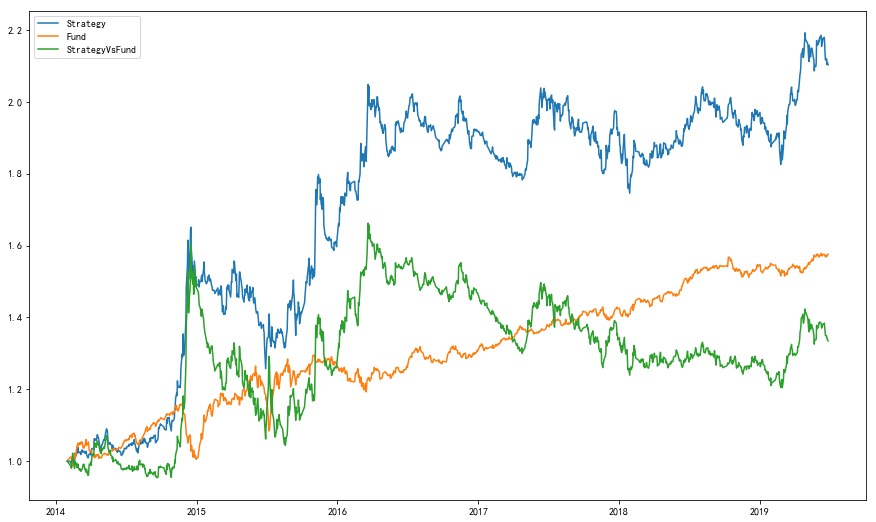

In [415]:
# 超额净值
plt.figure(figsize=(15,9))
plt.plot(backtest[1][['equity_series']]/BenchmarkIndexSubEquity[['equity_series']],label='Strategy')
plt.plot(BenchmarkFundSubEquity[['equity_series']]/BenchmarkIndexSubEquity[['equity_series']],label='Fund')
plt.plot(backtest[1][['equity_series']]/BenchmarkFundSubEquity[['equity_series']],label='StrategyVsFund')
# plt.plot(BenchmarkIndexSubEquity[['equity_series']],label='Index')
plt.legend(loc=0)

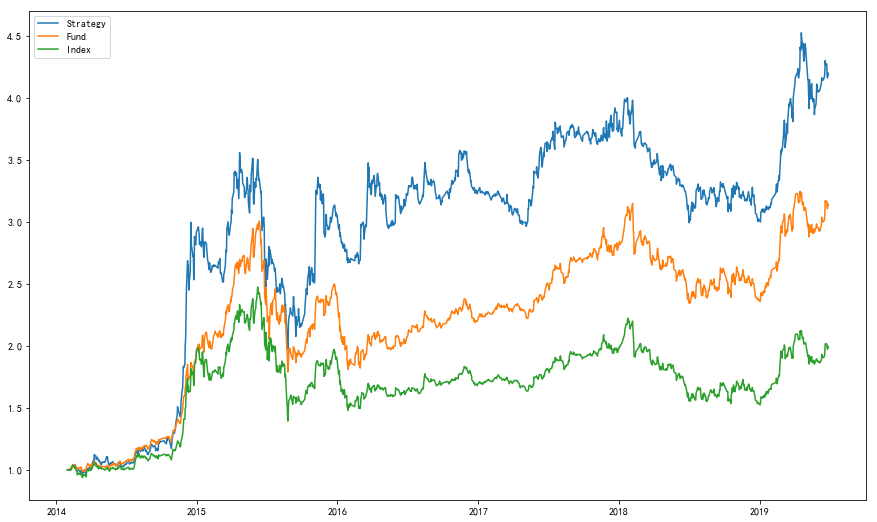

In [413]:
# 绝对净值
plt.figure(figsize=(15,9))
plt.plot(backtest[1][['equity_series']],label='Strategy')
plt.plot(BenchmarkFundSubEquity[['equity_series']],label='Fund')
plt.plot(BenchmarkIndexSubEquity[['equity_series']],label='Index')
plt.legend(loc=0)